<a href="https://colab.research.google.com/github/chaitsugale/Style-Transfer-using-CycleGAN/blob/main/Style_Transfer_MR1_T1_T2_Cyclic_GAN_Capstone_Project_Chaitanya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer Using Cyclic GAN Capstone Project

### By: Chaitanya Ugale

**Background** :

Misdiagnosis in the medical field is a very serious issue but it’s also uncomfortably common to occur. Imaging procedures in the medical field requires an expert radiologist’s opinion since interpreting them is not a simple binary process ( Normal or Abnormal). Even so, one radiologist may see something that another does not. This can lead to conflicting reports and make it difficult to effectively recommend treatment options to the patient.

One of the complicated tasks in medical imaging is to diagnose MRI(Magnetic Resonance Imaging). Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.

But to have access to different imaging is difficult and expensive. With the help of deep learning, we can use style transfer to generate artificial MRI images of different contrast levels from existing MRI scans. This will help to provide a better diagnosis with the help of an additional image.

**Problem Statement :**

To build a Generative adversarial model(modified U-Net) which can generate artificial MRI images of different contrast levels from existing MRI scans.

### Importing Packages

In [18]:
# Importing warning package
import warnings
warnings.filterwarnings('ignore')

# Importing all the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob
import os
import cv2
import pathlib

# importinf tensorflow libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,optimizers,metrics,Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [2]:
#loading the package for google drive

from google.colab import drive

#mounting content from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#unzipping the file

!unrar x "gdrive/MyDrive/MRI+T1_T2+Dataset.RAR" "/content/gdrive/MyDrive/"

#!unzip gdrive/MyDrive/MRI+T1_T2+Dataset -d '/content/gdrive/MyDrive/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from gdrive/MyDrive/MRI+T1_T2+Dataset.RAR

Creating    /content/gdrive/MyDrive/Tr1                               OK
Extracting  /content/gdrive/MyDrive/Tr1/.DS_Store                          0%  OK 
Creating    /content/gdrive/MyDrive/Tr1/TrainT1                       OK
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #10.png              1%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #11.png              2%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #12.png              3%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #13.png              4%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #14.png              5%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #15.png              6%  OK 
Extracting  /content/gdrive/MyDrive/Tr1/TrainT1/Image #16.png              7% 

Counts of File

In [4]:
#Defining the path of data

#for tr1
#tr1_data = pathlib.Path('/content/gdrive/MyDrive/Tr1/TrainT1')

#for tr2
#tr2_data = pathlib.Path('/content/gdrive/MyDrive/Tr2/TrainT2')

base_dir = pathlib.Path("/content/gdrive/My Drive")
os.chdir(base_dir)

tr1_data = pathlib.Path(str(base_dir) + "/Tr1/TrainT1")
tr2_data = pathlib.Path(str(base_dir) + "/Tr2/TrainT2")

print("Path for T1 data :\n", tr1_data)
print("Path for T2 data :\n", tr2_data)

Path for T1 data :
 /content/gdrive/My Drive/Tr1/TrainT1
Path for T2 data :
 /content/gdrive/My Drive/Tr2/TrainT2


In [5]:
!ls

 1517577920_PPG_ThinkEvil_Tshirt_SquareImage.png
 1517578044_Zakir-khan_Haq-se-single_JanhaviD.....png
 1520690500453_MonkeyCamActivity.java.gdoc
 20170226_142829.jpg
 20180112162229-1.jpg
 20180206114458-1.jpg
'abstract 2.pdf'
 ajax_tutorial.pdf
 android_tutorial.pdf
'angular (1).gdoc'
 angular.gdoc
 anime.jpg
'APIGEE - Analytics Services (1).gdoc'
'APIGEE - Analytics Services (2).gdoc'
'APIGEE - Analytics Services.gdoc'
'AWS (1).gdoc'
'Azure Essentials Q&A (1).gdoc'
'Azure Essentials Q&A.gdoc'
'Azure Virtual mc (1).gdoc'
'Azure Virtual mc (2).gdoc'
'Azure Virtual mc.gdoc'
 bgc.pdf
'bharti aadhar.pdf'
'bharti sbi.pdf'
'Block Chain (2) (1).gdoc'
'Block Chain (2) (2).gdoc'
'Block Chain (2) (3).gdoc'
'Block Chain (2).gdoc'
 bonafide_1458508_1578333021539.pdf
 carryled.asm
 CCCCC.pdf
'cd (1).gdoc'
 cd.gdoc
 chaitanya1.pdf
 chaitanya2.pdf
'chaitanya payment exam.pdf'
'Chaitanya Resume.docx'
'Chaitanya Resume.pdf'
'chaitanya rtes practical'
'Chaitanya seminar presentation.pptx'
'chaitanya S

## Step 1 : Data Understanding

In [6]:
# Checking the image count 

image_count_tr1 = len(list(tr1_data.glob('*.png')))

image_count_tr2 = len(list(tr2_data.glob('*.png')))

print('No. of image in TR1 : ',image_count_tr1)

print('No. of image in TR2 : ',image_count_tr2)

No. of image in TR1 :  43
No. of image in TR2 :  46


In [7]:
# sample to check the image size

mr1_sample = cv2.imread('/content/gdrive/MyDrive/Tr1/TrainT1/Image #34.png')

mr1_sample.shape

(217, 181, 3)

In [44]:
# The input shape for image should be (256, 256) so we are setting the image size

image_height = 217
image_width = 181

In [45]:
# setting up default batch size

mr1_batch_size = 64

### Loading Image

In [46]:
t1_image = image_dataset_from_directory(tr1_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 43 files belonging to 1 classes.


In [47]:
t2_image = image_dataset_from_directory(tr2_data,seed=123,shuffle = True,labels = None,image_size = (image_height,image_width),batch_size = mr1_batch_size )

Found 46 files belonging to 1 classes.


### Data Visualization

TR1 IMAGE


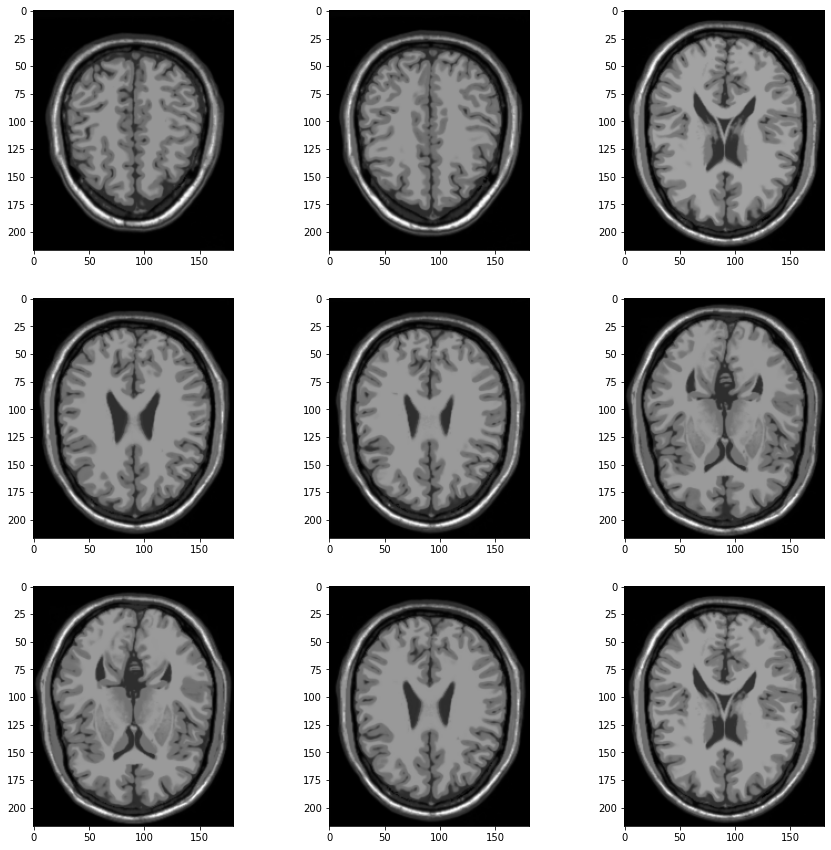

In [48]:
plt.figure(figsize=(15,15))
  
print("TR1 IMAGE")

for images in t1_image.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

TR2 IMAGE


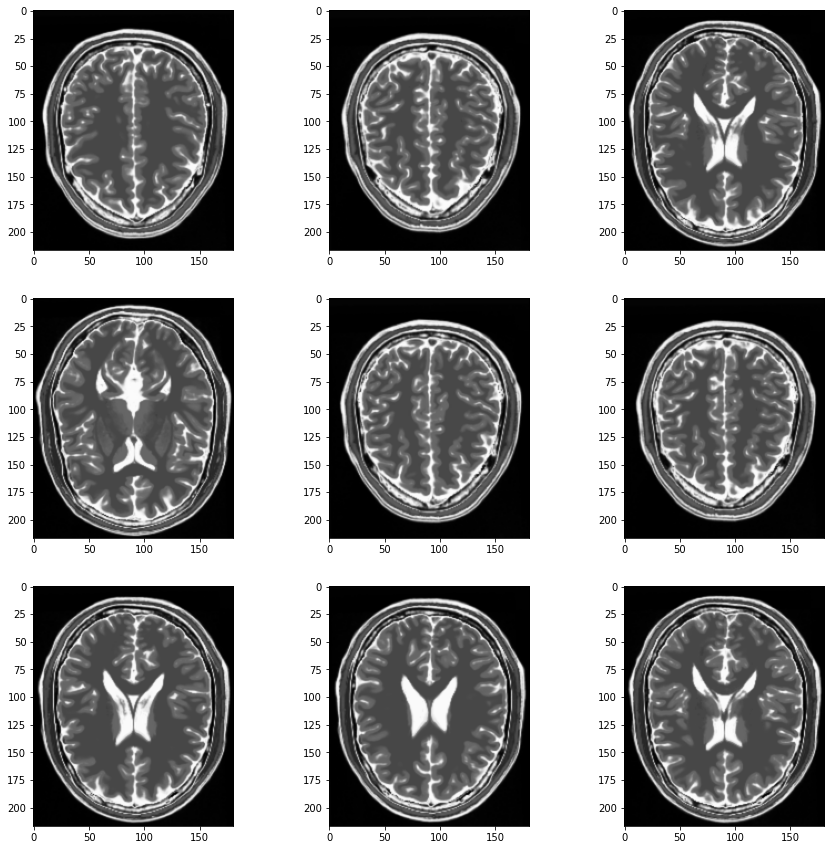

In [49]:
plt.figure(figsize=(15,15))
  
print("TR2 IMAGE")

for images_1 in t2_image.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images_1[i].numpy().astype('uint8'))

In [50]:
# checking the range of value of pixel making up the image in T1 data

image_batch_t1 = next(iter(t1_image))

first_image = image_batch_t1[0]

print('Pixel Value Range of T1 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T1 Image is from  0.0  to  255.0


In [51]:
# checking the range of value of pixel making up the image in T2 data

image_batch_t2 = next(iter(t1_image))

first_image = image_batch_t2[0]

print('Pixel Value Range of T2 Image is from ',np.min(first_image),' to ',np.max(first_image))

Pixel Value Range of T2 Image is from  0.0  to  255.0


## Step 2 : Data Preprocessing

### A. Data Normalization

In [58]:
# Defining normalization layer

normalization_layer  =  layers.experimental.preprocessing.Rescaling(scale=1./127.5,offset = -1.0)

In [59]:
# Normalizing T1 Images

normalize_t1 = t1_image.map(lambda x: (normalization_layer(x)))

image_batch1 = next(iter(normalize_t1))

first_image = image_batch1[0]

print('After Normalization : ')

print('Minimum : ',np.min(first_image),' Maximum : ',np.max(first_image))

After Normalization : 
Minimum :  -1.0  Maximum :  1.0
